# Klassifikation der in scikit-learn vektorisierten Daten (themes_only)

Autorin: Maria Hartmann

In [1]:
# Imports
import os
import time
import pandas as pd
import numpy as np
import scipy.sparse
from matplotlib import pyplot
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.neural_network import MLPClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Embedding, Dense, LSTM, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


c:\users\hartmann\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Einlesen der vektorisierten Daten

In [2]:
trainset_labels = '../Datasets/themes_only_train_idents_labels.csv' 
testset_labels = '../Datasets/themes_only_test_idents_labels.csv' 

trainset_csv = pd.read_csv(trainset_labels, delimiter=';')
y_train = trainset_csv['classes'].values
z_train = trainset_csv['url'].values
train_vectors = trainset_csv['filename'].values

testset_csv = pd.read_csv(testset_labels, delimiter=';')
y_test = testset_csv['classes'].values
z_test = testset_csv['url'].values
test_vectors = testset_csv['filename'].values

# Splitten der Labels pro Blogbeitrag
y_train = [e.split(', ') for e in y_train]
y_test = [e.split(', ') for e in y_test]

In [3]:
if len(set(train_vectors)) == 1:
    X_train = scipy.sparse.load_npz('../%s' % train_vectors[0])
else:
    print("Error with len(set(train_vectors))")
if len(set(test_vectors)) == 1:
    X_test = scipy.sparse.load_npz('../%s' % test_vectors[0])
else:
    print("Error with len(set(test_vectors))")

In [4]:
print(z_train[0])
print(y_train[0])
print(test_vectors[0])
print(X_train.shape)
X_train

ordensgeschichte.hypotheses.org/6160
['histoire_t', 'époque moderne_t', 'moyen âge_t']
Datasets/themes_only_test_scikit-learn_sparse_matrix.npz
(17109, 10000)


<17109x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 2389735 stored elements in Compressed Sparse Row format>

In [5]:
dim = X_train.shape[1]
print(dim)

10000


In [6]:
output_dir = "../themes_only" 
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

k-hot-Kodierung der Labels

In [7]:
# k-hot-encode labels mit MultiLabelBinarizer
label_encoder = MultiLabelBinarizer()
encoded_y_train = label_encoder.fit_transform(y_train)
encoded_y_test = label_encoder.transform(y_test)
print(encoded_y_train[0])

[0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0]


In [8]:
print(len(label_encoder.classes_))
for i, element in enumerate(label_encoder.classes_):
    print(i, element)

21
0 anthropologie_t
1 asie_t
2 droit_t
3 ethnologie_t
4 europe_t
5 géographie_t
6 histoire_t
7 information_t
8 langage_t
9 moyen âge_t
10 pensée_t
11 psychisme_t
12 religions_t
13 représentations_t
14 sociologie_t
15 éducation_t
16 épistémologie et méthodes_t
17 époque contemporaine_t
18 époque moderne_t
19 études des sciences_t
20 études du politique_t


# Klassifikation mit MLPClassifier

In [9]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(2048, 512), validation_fraction=0.1, early_stopping=True, verbose=True, random_state=1)
mlp_start = time.time()
mlp_clf = mlp_clf.fit(X_train, encoded_y_train)
mlp_time = (time.time() - mlp_start)/60

Iteration 1, loss = 4.99724264
Validation score: 0.475745
Iteration 2, loss = 2.26204605
Validation score: 0.606663
Iteration 3, loss = 1.11150565
Validation score: 0.624781
Iteration 4, loss = 0.50408517
Validation score: 0.623027
Iteration 5, loss = 0.24275951
Validation score: 0.614261
Iteration 6, loss = 0.16684479
Validation score: 0.607832
Validation score did not improve more than tol=0.000100 for two consecutive epochs. Stopping.


In [ ]:
print(mlp_time)
mlp_predicted = mlp_clf.predict(X_test)

In [11]:
mlp_precision = precision_score(encoded_y_test, mlp_predicted.round(), average='samples')
print(mlp_precision)
mlp_recall = recall_score(encoded_y_test, mlp_predicted.round(), average='samples')
print(mlp_recall)
mlp_f1 = f1_score(encoded_y_test, mlp_predicted.round(), average='samples')
print(mlp_f1)

0.8621218192746944
0.8009467040673212
0.8133429541213552


c:\users\hartmann\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
c:\users\hartmann\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [ ]:
loss_values = mlp_clf.loss_curve_
print(loss_values)
pyplot.title('Loss on training data (themes_only)')
pyplot.xlabel('epochs')
pyplot.ylabel('loss')
pyplot.plot(loss_values)
pyplot.savefig('%s/themes_only_mlp_plot_loss.png' % output_dir)
pyplot.show()

In [ ]:
validation_scores = mlp_clf.validation_scores_
print(validation_scores)
pyplot.title('Accuracy on validation data (themes_only)')
pyplot.xlabel('epochs')
pyplot.ylabel('acc')
pyplot.plot(validation_scores)
pyplot.savefig('%s/themes_only_mlp_plot_val_acc.png' % output_dir)
pyplot.show()

# Klassifikation mit Dense-Layer in Keras

In [25]:
# Keras model 

dense_model = Sequential()
dense_model.add(Dense(2048, input_dim=dim, activation="relu"))
dense_model.add(Dropout(0.4))
dense_model.add(Dropout(0.4))
dense_model.add(Dropout(0.4))
dense_model.add(Dense(512, activation="relu"))
dense_model.add(Dropout(0.4))
dense_model.add(Dropout(0.4))
dense_model.add(Dropout(0.4))
dense_model.add(Dense(len(label_encoder.classes_), activation="sigmoid"))

summary = dense_model.summary()
print("\n", summary)
config = dense_model.get_config()
print("\n", config)

# compile keras model
lossfunction = 'binary_crossentropy'
optimizer = "adam"
metrics = ['accuracy']

dense_model.compile(loss=lossfunction, 
              optimizer=optimizer,
              metrics=metrics)

callbacks_list = [EarlyStopping(monitor='val_loss', patience=7, verbose=10),
                  ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=10),
                 ]

# train keras model
batch_size = 32
epochs = 100
dense_start = time.time()
dense_estimator = dense_model.fit(X_train,
                            np.array(encoded_y_train), 
                            batch_size=batch_size,
                            epochs=epochs,
                            callbacks=callbacks_list,
                            verbose=10, 
                            validation_split=0.1,
                            shuffle=True
                           )

dense_time = (time.time() - dense_start)/60
print("Laufzeit in Minuten:", dense_time)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 2048)              20482048  
_________________________________________________________________
dropout_5 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
__________

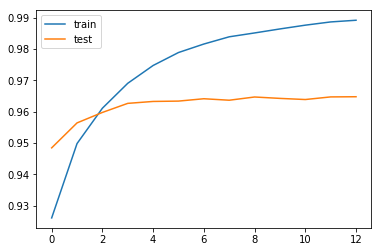

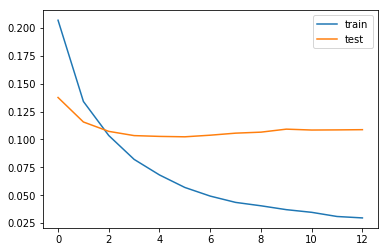

In [26]:
# visualize the train and validate loss and accuracy

# plot history for accuracy
pyplot.plot(dense_estimator.history['acc'], label='train')
pyplot.plot(dense_estimator.history['val_acc'], label='test')
pyplot.legend()
pyplot.savefig('%s/themes_only_dense_plot_acc.png' % output_dir)
pyplot.show()
pyplot.close()

# plot history for loss
pyplot.plot(dense_estimator.history['loss'], label='train')
pyplot.plot(dense_estimator.history['val_loss'], label='test')
pyplot.legend()
pyplot.savefig('%s/themes_only_dense_plot_loss.png' % output_dir)
pyplot.show()
pyplot.close()

In [27]:
print(dense_time)
dense_predicted = dense_model.predict_proba(X_test)

51.15669360955556


In [28]:
print(dense_predicted[0].round())
print(encoded_y_test[0])

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0]


In [29]:
dense_precision = precision_score(encoded_y_test, dense_predicted.round(), average='samples')
print(dense_precision)
dense_recall = recall_score(encoded_y_test, dense_predicted.round(), average='samples')
print(dense_recall)
dense_f1 = f1_score(encoded_y_test, dense_predicted.round(), average='samples')
print(dense_f1)

0.8671770297646876
0.8522907900888267
0.8490243043538975


c:\users\hartmann\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
c:\users\hartmann\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


Ohne Dropout:

Precision: 0.857538569424965
Recall: 0.8122954651706404
F1-Score: 0.8195001507764481

Mit einer Dropout-Schicht (0,4):

Precision: 0.8632226897304036
Recall: 0.829153031011376
F1-Score: 0.8331697223352202

Mit drei Dropout-Schichten (0,4):

Precision: 0.8671770297646876
Recall: 0.8522907900888267
F1-Score: 0.8490243043538975

# Klassifikation mit LSTM-Layer in Keras

In [9]:
# reshape input data from 2D to 3D for MLP input layer
def reshape_input(text_vectors):
    text_vectors = scipy.sparse.csr_matrix.toarray(text_vectors)
    data = np.expand_dims(text_vectors, axis=2)
    return data

# reshape vectorized trainingdata (X_train)
X_train_3d = reshape_input(X_train)
# reshape vectorized testdata (X_test)
X_test_3d = reshape_input(X_test)

print("shape X_train:", X_train.shape)
print("newshape X_train:", X_train_3d.shape)
print("newshape X_test:", X_test_3d.shape)

shape X_train: (17109, 10000)
newshape X_train: (17109, 10000, 1)
newshape X_test: (4278, 10000, 1)


In [18]:
print(type(X_train_3d))
print(len(X_train_3d))
print(type(X_train_3d[0]))
print(len(X_train_3d[0]))
print(type(X_train_3d[0][0]))
print(len(X_train_3d[0][0]))
print(type(X_train_3d[0][1]))
print(len(X_train_3d[0][1]))
print(type(X_train_3d[0][2]))


<class 'numpy.ndarray'>
17109
<class 'numpy.ndarray'>
10000
<class 'numpy.ndarray'>
1
<class 'numpy.ndarray'>
1
<class 'numpy.ndarray'>


In [23]:
# LSTM in Keras
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=dim, output_dim=64))
lstm_model.add(LSTM(32, activation="relu"))
lstm_model.add(Dropout(0.4))

lstm_model.add(Dense(len(label_encoder.classes_), activation="sigmoid"))

summary = lstm_model.summary()
print("\n", summary)
config = lstm_model.get_config()
print("\n", config)

# compile keras model
lossfunction = 'binary_crossentropy'
optimizer = "adam"
metrics = ['accuracy']

lstm_model.compile(loss=lossfunction,
                   optimizer=optimizer,
                   metrics=metrics)

callbacks_list = [EarlyStopping(monitor='val_loss', patience=4, verbose=10),
                  ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=10),
                 ]

# train keras model
batch_size = 32
epochs = 100
lstm_start = time.time()
lstm_estimator = lstm_model.fit(X_train,
                            encoded_y_train, 
                            batch_size=batch_size,
                            epochs=epochs,
                            callbacks=callbacks_list,
                            verbose=10, 
                            validation_split=0.1,
                            shuffle=True
                           )

lstm_time = (time.time() - lstm_start)/60
print("Laufzeit in Minuten:", lstm_time)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
lstm_10 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 21)                693       
Total params: 329,013
Trainable params: 329,013
Non-trainable params: 0
_________________________________________________________________

 None

 [{'class_name': 'Embedding', 'config': {'name': 'embedding_5', 'trainable': True, 'batch_input_shape': (None, None), 'dtype': 'float32', 'input_dim': 10000, 'output_dim': 32, 'embeddings_initializer': {'class_name': 'RandomUniform', 'config': {'minval': -0.05

c:\users\hartmann\appdata\local\programs\python\python36\lib\site-packages\keras\callbacks.py:529: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):
c:\users\hartmann\appdata\local\programs\python\python36\lib\site-packages\keras\callbacks.py:953: RuntimeWarning: invalid value encountered in less
  self.monitor_op = lambda a, b: np.less(a, b - self.min_delta)


Epoch 2/100

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 3/100
Epoch 4/100

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 00004: early stopping
Laufzeit in Minuten: 170.94995508591333


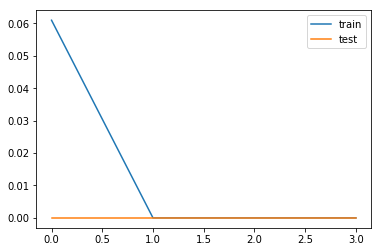

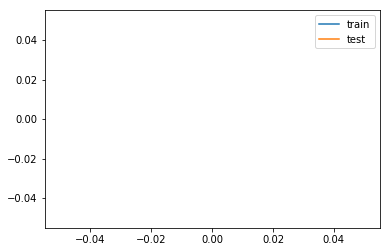

In [24]:
# visualize the train and validate loss and accuracy

# plot history for accuracy
pyplot.plot(lstm_estimator.history['acc'], label='train')
pyplot.plot(lstm_estimator.history['val_acc'], label='test')
pyplot.legend()
pyplot.savefig('%s/themes_only_lstm_plot_acc.png' % output_dir)
pyplot.show()
pyplot.close()

# plot history for loss
pyplot.plot(lstm_estimator.history['loss'], label='train')
pyplot.plot(lstm_estimator.history['val_loss'], label='test')
pyplot.legend()
pyplot.savefig('%s/themes_only_lstm_plot_loss.png' % output_dir)
pyplot.show()
pyplot.close()

In [18]:
#print(lstm_time)
lstm_predicted = lstm_model.predict_proba(X_test)

c:\users\hartmann\appdata\local\programs\python\python36\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
c:\users\hartmann\appdata\local\programs\python\python36\lib\site-packages\keras\models.py:1152: RuntimeWarning: invalid value encountered in less
  if preds.min() < 0. or preds.max() > 1.:
c:\users\hartmann\appdata\local\programs\python\python36\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
c:\users\hartmann\appdata\local\programs\python\python36\lib\site-packages\keras\models.py:1152: RuntimeWarning: invalid value encountered in greater
  if preds.min() < 0. or preds.max() > 1.:


In [19]:
lstm_precision = precision_score(encoded_y_test, lstm_predicted.round(), average='samples')
print(lstm_precision)
lstm_recall = recall_score(encoded_y_test, lstm_predicted.round(), average='samples')
print(lstm_recall)
lstm_f1 = f1_score(encoded_y_test, lstm_predicted.round(), average='samples')
print(lstm_f1)

ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets